# Classification and Regression Trees

## Monday November 7, 2016



Fill in missing code

### Classification

In [34]:
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline


##### Read, Explore, and Process data

In [35]:
# Read in the data
titanic = pd.read_csv('titanic.csv')

# Take a  selection of the features
d = titanic[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]

In [36]:
# Check for missing values in all columns
d.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
dtype: int64

In [37]:
# Check for missing values in Age column, after grouping by other columns
d.groupby(['Sex', 'Pclass']).Age.apply(lambda x: x.isnull().sum()) / d.groupby(['Sex', 'Pclass']).Age.count()

Sex     Pclass
female  1         0.105882
        2         0.027027
        3         0.411765
male    1         0.207921
        2         0.090909
        3         0.371542
Name: Age, dtype: float64

In [38]:
# Fill in missing values with the mean value (use .fillna())
d['Age'] = d['Age'].fillna(d['Age'].mean())

/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [39]:
# Convert any text categorical features to numeric for scikit learn
d['Sex'] = np.where(d.Sex == 'female', 1, 0)

/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [40]:
# Explore the data to identify trends in characteristics of survivors
d.Survived.value_counts()                    # How many people lived and died
d.Survived.mean()                            # The survival rate for everyone
d.groupby('Sex').Survived.mean()             # By Sex: women have higher survival rates
d.groupby('Pclass').Survived.mean()          # By Pclass: 1st class passengers have higher survival rates
d.groupby(['Sex', 'Pclass']).Survived.mean() # By Sex and Pclass: Women in the 1st and 2nd classes had the highest survival rates


Sex  Pclass
0    1         0.368852
     2         0.157407
     3         0.135447
1    1         0.968085
     2         0.921053
     3         0.500000
Name: Survived, dtype: float64

In [41]:
# Create a new feature representing whether the Spouse was on board
d['Spouse'] = ((d.Age > 18) & (d.SibSp >= 1)).astype(int)
d.Spouse.value_counts()
d.groupby(['Pclass', 'Spouse']).Survived.mean() # Having a spouse appears to increase survival in the 1st class only

/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Pclass  Spouse
1       0         0.575342
        1         0.742857
2       0         0.473684
        1         0.470588
3       0         0.240786
        1         0.250000
Name: Survived, dtype: float64

#### Split into training and test datasets, and build the model

In [42]:
survived = d['Survived']
del d['Survived']
d.head()

,Pclass,Sex,Age,SibSp,Parch,Spouse
0,3,0,22.0,1,0,1
1,1,1,38.0,1,0,1
2,3,1,26.0,0,0,0
3,1,1,35.0,1,0,1
4,3,0,35.0,0,0,0


In [43]:
# Now, split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(d,survived, random_state=1)

In [58]:
# Create a decision tree classifier object (start out with a small tree for interpretability)
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# Fit the decision tree classifier
treef = ctree.fit(X_train, y_train) # specifies the whole decision tree, can specify the depth though this default function does it auto

In [63]:
!pip install graphviz

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [64]:
!pip install pydotplus

    100% |████████████████████████████████| 286kB 1.5MB/s 
  Running setup.py bdist_wheel for pydotplus ... - \ done
  Stored in directory: /Users/jiaminlim93/Library/Caches/pip/wheels/43/31/48/e1d60511537b50a8ec28b130566d2fbbe4ac302b0def4baa48
Successfully built pydotplus
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [73]:
with open("d.dot", 'w') as f:
    f = tree.export_graphviz(treef, out_file=f)

In [74]:
# Visualising the decision tree
import os
os.unlink('d.dot')

In [75]:
import pydotplus 
dot_data = tree.export_graphviz(treef, out_file='tree') 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("tree.pdf") 

AttributeError: 'NoneType' object has no attribute 'startswith'

#### Confusion Matrix

In [45]:
# How to interpret the diagram?
ctree.classes_

array([0, 1])

For a plotting function that will plot a nice confusion matrix see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [46]:
# %load confusion_matrix_nice.py
# from confusion_matrix_nice import plot_confusion_matrix
%run confusion_matrix_nice

Confusion matrix, without normalization
[[119   9]
 [ 52  43]]


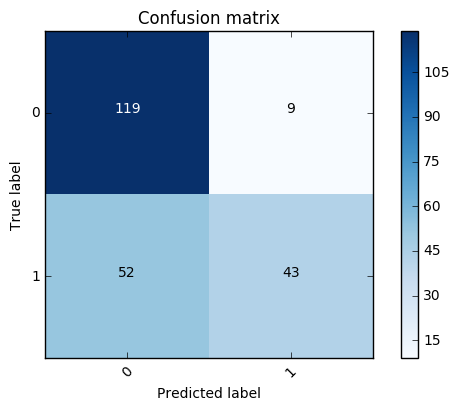

In [48]:
# get the predictions (not the probabilities)
y_pred_class = ctree.predict(X_test)

# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

#### Use the Model

In [49]:
# Create a feature vector for reference. We will create fictional values for test observations. 
features = X_train.columns.tolist()
features

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Spouse']

In [61]:
# Predict what will happen for 1st class woman
#features
ctree.predict_proba([1, 1, 25, 0, 0, 0])
ctree.predict([1, 1, 25, 0, 0, 0])


/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([1])

In [62]:

# Predict what will happen for a 3rd class man
ctree.predict_proba([3, 0, 25, 0, 0, 0])
ctree.predict([3, 0, 25, 0, 0, 0])


/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/jiaminlim93/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([0])

#### Evaluate

In [ ]:

# Which features are the most important? - sex
ctree.feature_importances_

# Make a Dataframe out of the features and the importance measure for the features
pd.DataFrame(zip(features, ctree.____________)).sort_index(by=1, ascending=False)

# Make predictions on the test set
preds = ctree.predict(X_test)

# Calculate accuracy
metrics.accuracy_score(y_test, preds)

# Confusion matrix
pd.crosstab(y_test, preds, rownames=['actual'], colnames=['predicted'])

# Make predictions on the test set using predict_proba
probs = ctree._________(X_test)[:,1]

# Calculate the AUC metric
metrics.roc_auc_score(y_test, probs)

# Decision Trees have notorouisly high variance, so what can we do
# to better estimate the out of sample error of a high variance model?



##### Compare against Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# compare AUC using cross-validation
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, d, survived, cv=10, scoring='roc_auc').mean() #auc:area under the curve
cross_val_score(ctree, d, survived, cv=10, scoring='roc_auc').mean()

# so far logistic regression is winning..


##### FINE-TUNING THE TREE

In [ ]:

from sklearn.grid_search import GridSearchCV

# check CV score for max depth = 3
ctree = tree.DecisionTreeClassifier(max_depth=3)
np.mean(cross_val_score(ctree, d, survived, cv=5, scoring='roc_auc'))

# check CV score for max depth = 10
ctree = tree.DecisionTreeClassifier(max_depth=10)
np.mean(cross_val_score(ctree, d, survived, cv=5, scoring='roc_auc'))

In [ ]:

# Conduct a grid search for the best tree depth
ctree = tree.DecisionTreeClassifier(random_state=1)
depth_range = range(1, 20)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5, scoring='roc_auc')
grid.fit(d, survived)



In [ ]:

# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]


# Plot the results of the grid search
plt.figure()
plt.plot(depth_range, grid_mean_scores)
plt.hold(True)
plt.grid(True)
plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')


In [ ]:

# Get the best estimator
best = grid.best_estimator_

cross_val_score(best, d, survived, cv=10, scoring='roc_auc').mean()
cross_val_score(logreg, d, survived, cv=10, scoring='roc_auc').mean()


# Still not as good as Logistic Regression.. 
# Let's try something else



### EXERCISE ###
''' Use Grid Search try scan over three parameters
1. max_depth:     from 1 to 20
2. criterion:     (either 'gini' or 'entropy')
3. max_features : range (1,5)

'''


### Regression

In [ ]:
# Decision trees (like many other classification models)
# can also be used for regression!


drinks = pd.read_csv('drinks.csv', na_filter=False)

drinks

# Make dummy columns for each of the 6 regions
for continent_ in ['AS', 'NA', 'EU', 'AF', 'SA', 'OC']:
    drinks[continent_] = drinks['continent'] == continent_

drinks


del drinks['continent']
del drinks['country']
del drinks['total_litres_of_pure_alcohol'] # this doesn't seem fair does it?

X = drinks.drop('wine_servings', axis=1)
y = drinks['wine_servings']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)


rtree = tree.DecisionTreeRegressor()

rtree.fit(X_train, y_train)
rtree.predict(X_test)

scores = - cross_val_score(rtree, X, y, cv=10, scoring='neg_mean_squared_error')
mse_scores = scores
mse_scores
rmse_scores = np.sqrt(mse_scores)
rmse_scores
rmse_scores.mean()

wine_mean = y.mean()
wine_mean

features = X.columns
pd.DataFrame(zip(features, rtree.feature_importances_)).sort_values(by=1, ascending=False)

